Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.
Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 29s 993ms/step - accuracy: 0.4858 - loss: 1.3115 - val_accuracy: 0.6311 - val_loss: 0.7710
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 923ms/step - accuracy: 0.6959 - loss: 0.6738 - val_accuracy: 0.7476 - val_loss: 0.5592
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 943ms/step - accuracy: 0.7549 - loss: 0.5801 - val_accuracy: 0.7573 - val_loss: 0.5657
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 928ms/step - accuracy: 0.7818 - loss: 0.4551 - val_accuracy: 0.8058 - val_loss: 0.5330
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 949ms/step - accuracy: 0.7995 - loss: 0.4676 - val_accuracy: 0.7961 - val_loss: 0.5781
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 926ms/step - accuracy: 0.8287 - loss: 0.4020 - val_accuracy: 0.7961 - val_loss: 0.5599
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 939ms/step - accuracy: 0.8392 - loss: 0.4071 - val_accuracy:

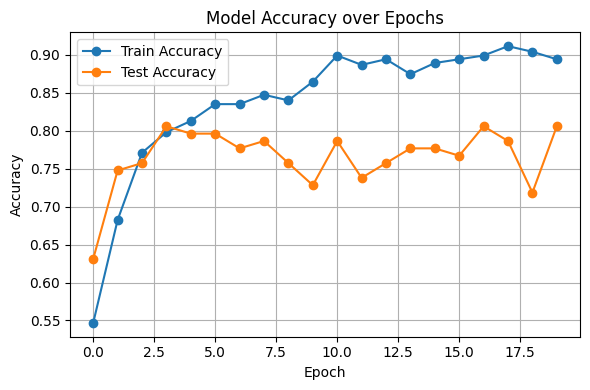

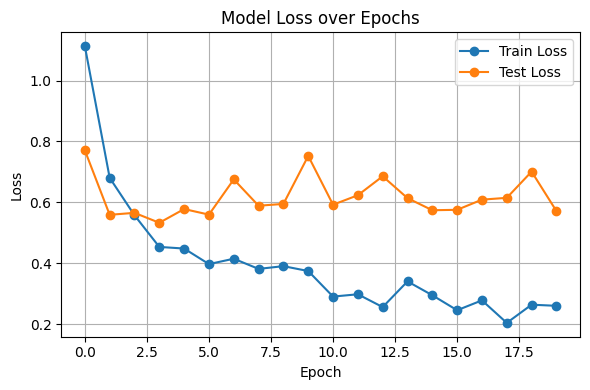

In [4]:
import os
import random
import numpy as np
import tensorflow as tf
import pickle
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input

seed = 40
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ---- Paths ----
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'

# ---- Hyperparameters ----
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.001
target_size = (224, 224)  # MobileNet input size
num_classes = 3  # Assuming 3 classes for lung cancer

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
# ---- Data Preprocessing ----
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=True, seed=seed
)
val_generator = datagen.flow_from_directory(
    val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)
test_generator = datagen.flow_from_directory(
    test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

# ---- Define Model ----
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# ---- Compile Model ----
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# ---- Train Model ----
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    batch_size=batch_size,
    verbose=1
)

# ---- Evaluate Model ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

#Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

import numpy as np
import pickle
# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'mobileNetv2_cv(new).pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

94/94 ━━━━━━━━━━━━━━━━━━━━ 52s 517ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.83      0.27      0.40       500
               Nor       0.60      1.00      0.75       500
Squamous_carcinoma       0.73      0.73      0.73       500

          accuracy                           0.67      1500
         macro avg       0.72      0.67      0.63      1500
      weighted avg       0.72      0.67      0.63      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.77      0.85      0.80        39
               Nor       0.92      0.71      0.80        31
Squamous_carcinoma       0.78      0.85      0.81        33

          accuracy                           0.81       103
         macro avg       0.82      0.80      0.81       103
      weighted avg       0.82      0.81      0.81       103

Validation Accuracy: 0.66

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 689ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.93
Nor - AUC: 0.93
Squamous_carcinoma - AUC: 0.93


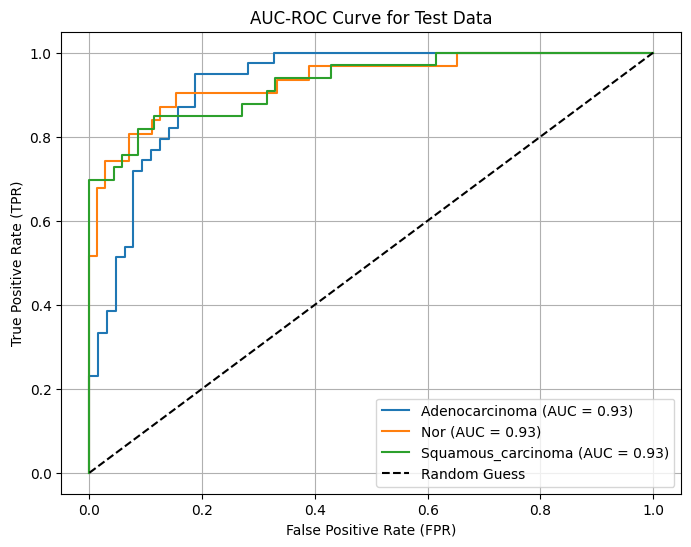


Macro-Averaged Test AUC: 0.93
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 630ms/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.85
Nor - AUC: 0.96
Squamous_carcinoma - AUC: 0.89


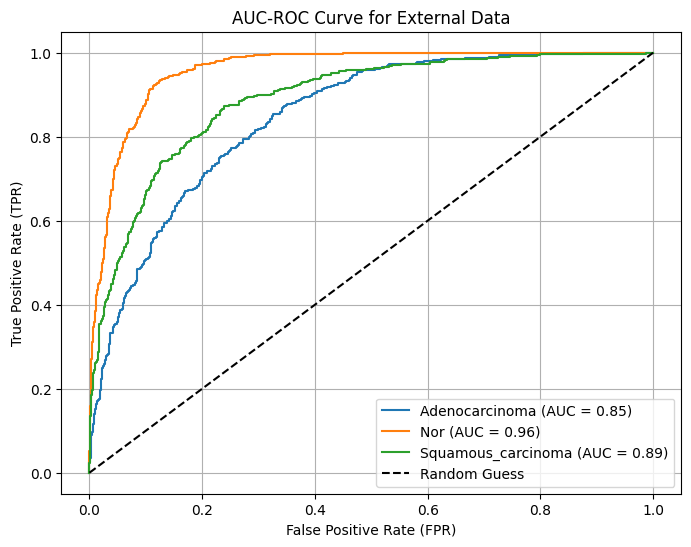


Macro-Averaged Test AUC: 0.90


In [8]:
# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")